# <span style="color: #674172">Mask detection</span>
### <span style="color: #674172">using Prajna Bhandary <a href=https://www.kaggle.com/chandrasekarank/prajna-bhandary-face-mask-detection-dataset>dataset</a> and Adrian Rosebrock <a href=https://towardsdatascience.com/a-complete-anomaly-detection-algorithm-from-scratch-in-python-step-by-step-guide-e1daf870336e>tutorial</a></span>

## <span style="color: #674172">Part 2. Mask detection for new images</span>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

%matplotlib inline

## <span style="color: #674172">0. Face detection with OpenCV</span>

In [2]:
# Load HAAR cascade for face detection

face_cascade_front = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
face_cascade_profile = cv2.CascadeClassifier("haarcascade_profileface.xml")

In [3]:
# Load previosly trained model for mask detection

detector_model = load_model('.\\model\\model')

In [4]:
# Define function that checks if to images overlap

def is_overlaping(coord_1, coord_2):
    (x1, y1, w1, h1) = coord_1
    (x2, y2, w2, h2) = coord_2
    x12 = x1 + w1
    y12 = y1 + h1
    x22 = x2 + w2
    y22 = y2 + h2
    
    square_1 = (x12 - x1) * (y12 - y1)
    square_2 = (x22 - x2) * (y22 - y2)
    
    square_of_interception = max(0, min(x12, x22) - max(x1, x2)) * max(0, min(y12, y22) - max(y1, y2))
    
    if square_of_interception / (square_1 + square_2) > 0.3:
        return True
    
    return False

In [5]:
# Define function that loads image, finds faces and crops image accordingly

def find_faces(path, face_detector, extra_detector=False):
    face_list = []
    coordinates_list = []
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(image, 1.1, 3)
    for (x, y, w, h) in faces:
        cropped_img = image[y:y + h, x:x + w].copy()
        face_list.append(cropped_img)
        coordinates_list.append((x, y, w, h))
        
    if extra_detector:
        extra_faces = extra_detector.detectMultiScale(image, 1.1, 3)
        for (x, y, w, h) in extra_faces:
            overlaping = False
            for (x1, y1, w1, h1) in faces:
                if is_overlaping((x, y, w, h), (x1, y1, w1, h1)):
                    overlaping = True
            if not overlaping:
                cropped_img = image[y:y + h, x:x + w].copy()
                face_list.append(cropped_img)
                coordinates_list.append((x, y, w, h))

    return face_list, coordinates_list, image

## <span style="color: #674172">1. Face images preprocessing</span>

In [6]:
# Define function that preprocesses image and detects mask

def mask_detector(face, detector):
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    (mask, without_mask) = detector.predict(face)[0]
    label = 'Mask' if mask > without_mask else 'No mask'
    return label

## <span style="color: #674172">2. Mask detection</span>

In [7]:
# Create a list of new images paths

image_paths = []

for path, subdirs, files in os.walk('.\\new_images\\'):
    for name in files:
        image_paths.append(os.path.join(path, name))

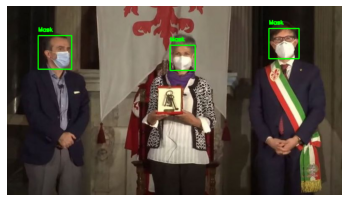

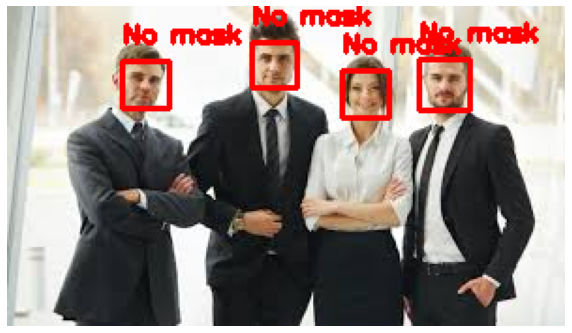

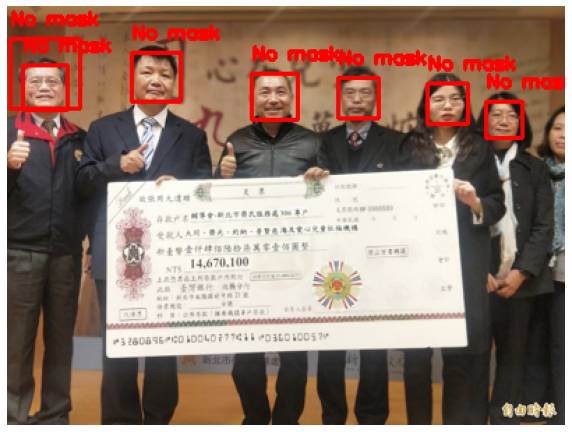

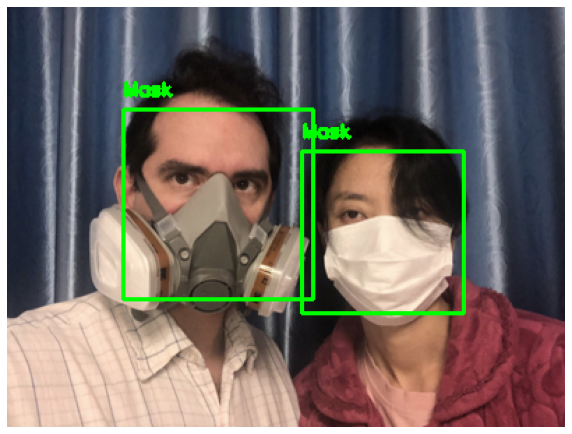

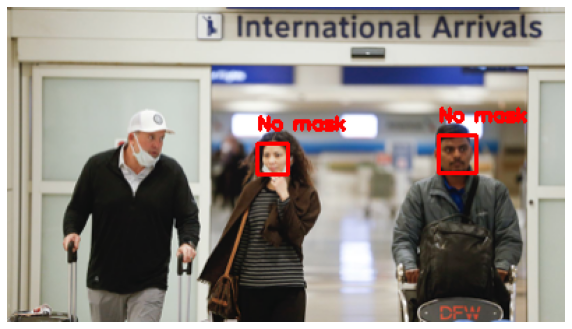

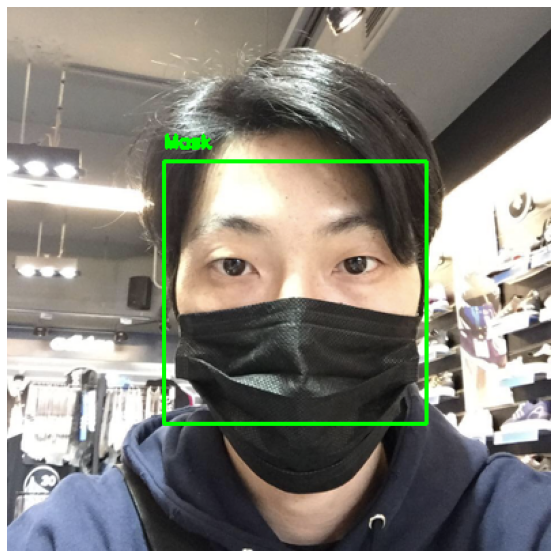

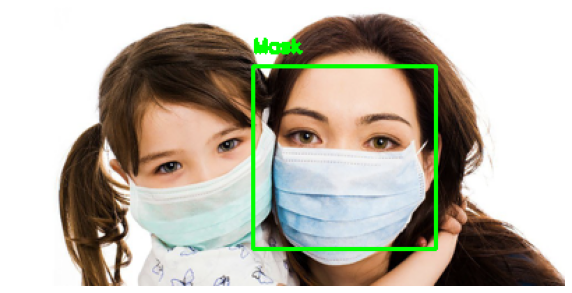

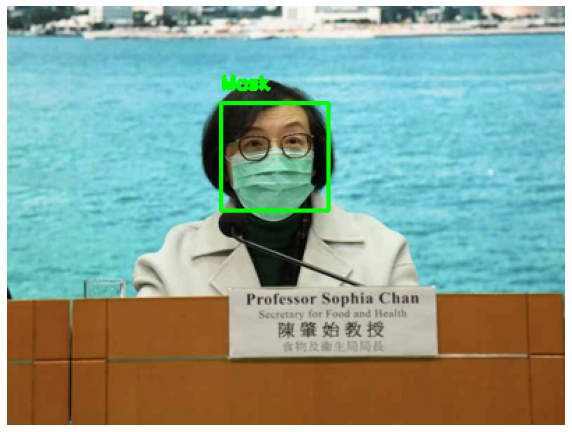

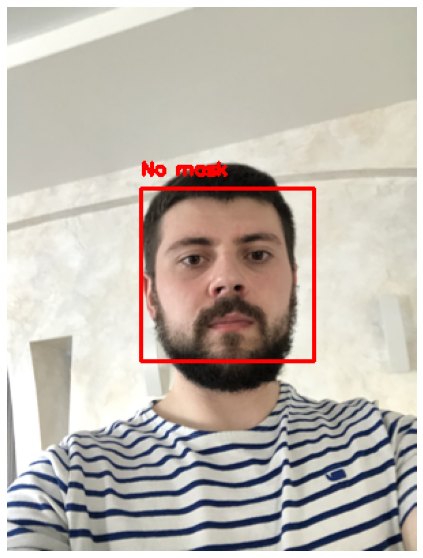

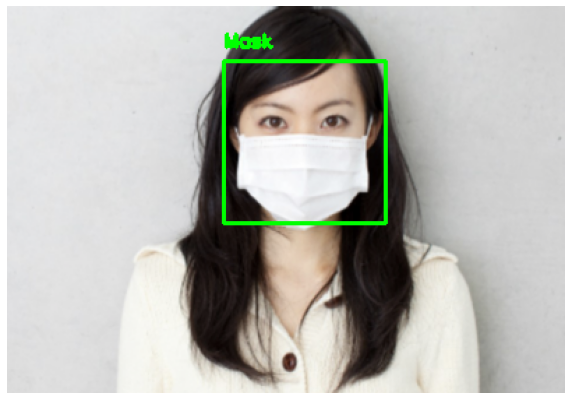

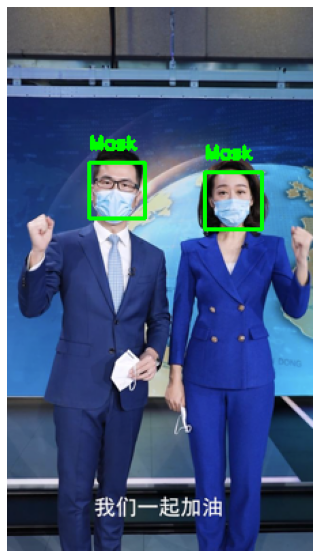

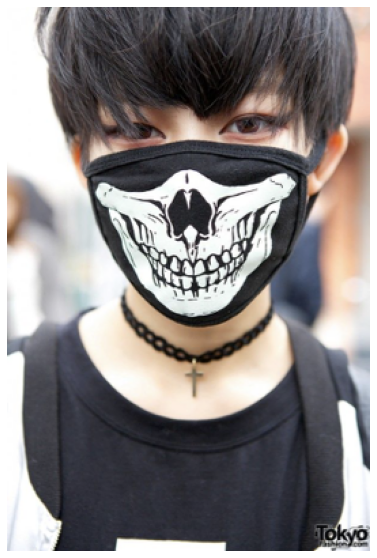

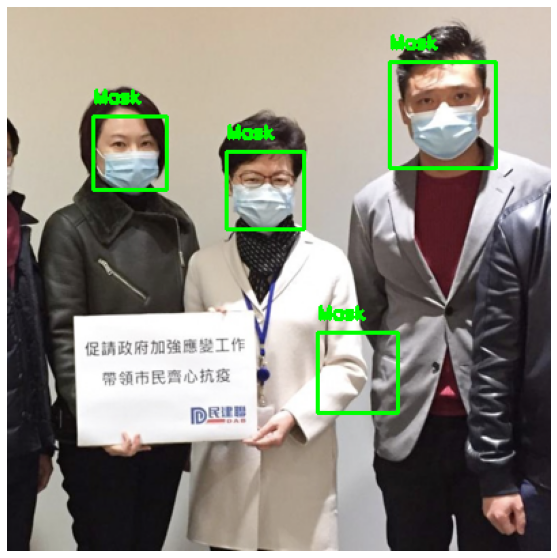

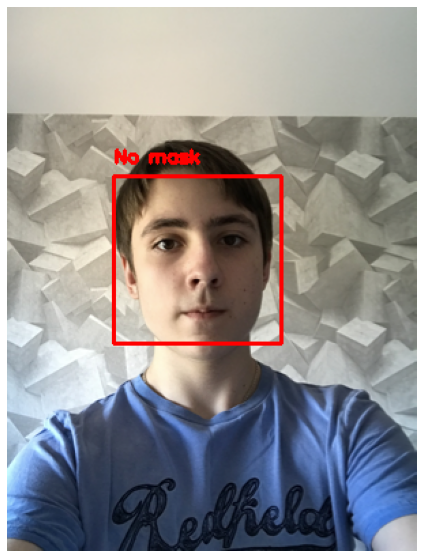

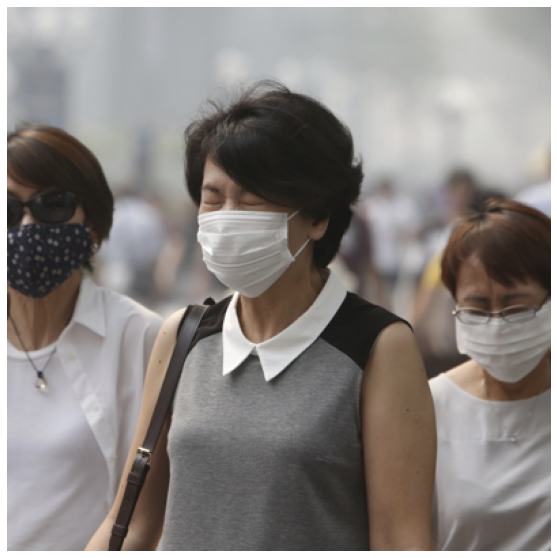

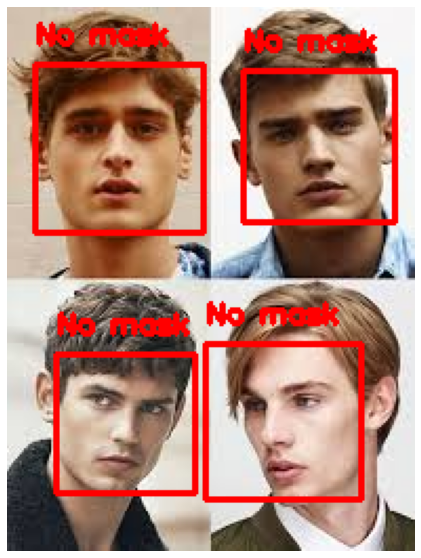

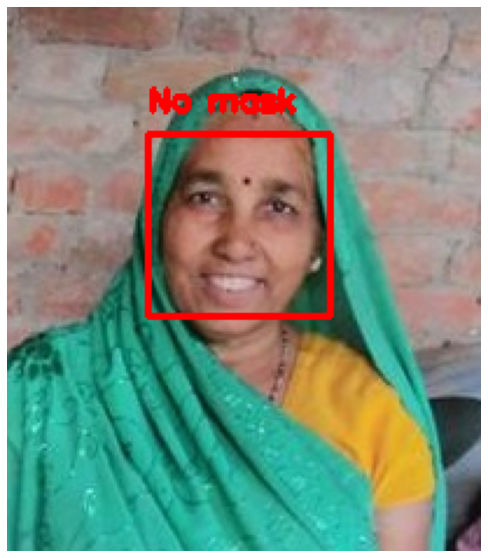

In [8]:
# Process all images in the 'new_images' folder

for path in image_paths:
    (faces, coordinates, image) = find_faces(path, face_cascade_front, face_cascade_profile)
    labels = []
    for i in range(len(faces)):
        (x, y, w, h) = coordinates[i]
        label = mask_detector(faces[i], detector_model)
        color = (0, 255, 0) if label == 'Mask' else (255, 0, 0)
        cv2.putText(image, label, (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show()     